In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [12]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import logging
logging.basicConfig(level=logging.CRITICAL) # ignore no handles to put in legend warning from matplotlib
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # ignore Future deprecation warning
import os
import pickle

from classes import boundaries as bd
from classes import snag_MTF_func as sg

plot_setup = bd.plot_setup()
params = {'mathtext.default':'regular'}
plt.rcParams.update(params)

%matplotlib inline
%config Completer.use_jedi = False 




#--- Notebook run settings
run = 'command line' # 'manual' 'command line'
#run = 'manual'


# Settings for the multiple linear regression model (MLR)
#--- Arguments
if run == 'command line':
    # Read command line arguments
    arguments = os.environ['NB_ARGS']
    alpha, date_exp_str, remove_data = arguments.split(',')
    
    alpha              = float(alpha)   
    remove_data        = bool(remove_data)
    
elif run == 'manual':
    # Enter arguments manually 
    alpha              = 0.01
    date_exp_str       = '230207_Full'
    remove_data        = True
    
# Mortality group?
if 'Fire' not in date_exp_str:
    mort_group = 'M_All'
elif 'NoFire' in date_exp_str:
    mort_group ='M_NoFire'
elif 'Only' in date_exp_str:
    mort_group = 'M_Fire'
elif 'Insects' in date_exp_str:
    mort_group = 'M_Other'
    
print(date_exp_str, alpha, remove_data, mort_group)       

230117_Fulli_NoFire 0.01 True M_NoFire


In [13]:
#---------------#
#  Import data  #
#---------------#
mtf_type = ['count','cmass']
standardise_covars_list = [False, True]

# Initialise storage
if ('Fire' not in date_exp_str) | ('Management' not in date_exp_str):
    climate_data_list  = ['CRUclim','CRUNCEPv7','CHELSA30s', 'WorldClim30s','WorldClim10m']
else:
    climate_data_list  = ['CRUNCEPv7'] # Only analysing CRUobs for mort subsets

res_data = np.empty((len(climate_data_list),len(standardise_covars_list),len(mtf_type),2),dtype='object') # table; res_objects
for c,climate_data in enumerate(climate_data_list):
    
    load_pickle_str='site_reg_results/'+date_exp_str+'_SITE_'+str(alpha)+'_'+climate_data+'.pkl'
    with open(load_pickle_str,'rb') as f:
        clim_data = pickle.load(f)
    
    for s in range(len(standardise_covars_list)):
        for t in range(len(mtf_type)):
                        
            res_data[c,s,t,0] = clim_data[s,t,0] # regression table
            res_data[c,s,t,1] = clim_data[s,t,1] # result objects

In [20]:
res_store = []

for t,tpe in enumerate(mtf_type[:]):
    #t += 1
    #print(t,tpe)
    bd.print_TITLE(tpe)
    clim_models = pd.concat(res_data[:,0,t,0],axis=0)
    clim_models.index.name = 'model'
    clim_models.reset_index(drop=False,inplace=True)
    
    clim_models = clim_models[clim_models.prms_sig == True].copy()
    display(clim_models)

    unique_models_across_climates = clim_models.model.unique().tolist()

    df_best_models = pd.DataFrame()
    

    for model in unique_models_across_climates[:]:

        clim_models_ss = clim_models[clim_models.model == model].copy()

        clim_models_ss.sort_values('r2',ascending = False,inplace=True)
        clim_models_ss.reset_index(drop=True,inplace=True)

        if (('MATsoil' in model) | ('MAP' in model) | ('DBH' in model) | ('CDI' in model)) == True:
            clim_models_ss.climate = np.nan

        df_best_models = pd.concat([df_best_models,clim_models_ss.iloc[0,:].to_frame().T])

    df_best_models_aic_sorted = df_best_models.sort_values('AIC') 
    #display(df_best_models_aic_sorted)
    df_best_models_aic_sorted_sig = df_best_models_aic_sorted[(df_best_models_aic_sorted.prms_sig == True)].copy()
    df_best_models_aic_sorted_sig = df_best_models_aic_sorted_sig.reset_index(drop=True).copy()
    df_best_models_aic_sorted_sig.d_AIC = abs(df_best_models_aic_sorted_sig.AIC.min() - 
                                              df_best_models_aic_sorted_sig.AIC)
    df_best_models_aic_sorted_sig.RMSE = df_best_models_aic_sorted_sig.RMSE.apply(lambda x: np.round(x,1))
    res_table = df_best_models_aic_sorted_sig[df_best_models_aic_sorted_sig.d_AIC <= 6].copy()
    res_table['Mortality'] = mort_group
    display(res_table)
    
    res_store.append(res_table)
    
with open('site_reg_results/'+date_exp_str+'_'+str(alpha)+'_'+str(remove_data)+'_SITE_best_Models_dAIC.pkl','wb') as f:
    pickle.dump(res_store,f)



             count             




,model,r2,AIC,d_AIC,RMSE,DWT,prms_sig,prms_fail,N_obs,ID,MTF_basis,climate,standardised_covars
3,MTF ~ MATsoil,0.31,114.4,0.6,23.61,1.52,True,,50.0,3,count,CRUclim,False
10,MTF ~ MAT,0.29,115.8,2.0,22.91,1.60,True,,50.0,10,count,CRUclim,False
17,MTF ~ CDI,0.18,122.7,8.9,24.69,1.37,True,,50.0,17,count,CRUclim,False
32,MTF ~ MATsoil,0.31,114.4,0.6,23.61,1.52,True,,50.0,5,count,CRUNCEPv7,False
33,MTF ~ MAT,0.31,114.5,0.7,22.75,1.62,True,,50.0,6,count,CRUNCEPv7,False
44,MTF ~ CDI,0.18,122.7,8.9,24.69,1.37,True,,50.0,17,count,CRUNCEPv7,False
57,MTF ~ MATsoil,0.31,114.4,0.6,23.61,1.52,True,,50.0,3,count,CHELSA30s,False
63,MTF ~ MAT,0.23,120.1,6.3,24.25,1.61,True,,50.0,9,count,CHELSA30s,False
71,MTF ~ CDI,0.18,122.7,8.9,24.69,1.37,True,,50.0,17,count,CHELSA30s,False
84,MTF ~ MATsoil,0.31,114.4,0.6,23.61,1.52,True,,50.0,3,count,WorldClim30s,False


,model,r2,AIC,d_AIC,RMSE,DWT,prms_sig,prms_fail,N_obs,ID,MTF_basis,climate,standardised_covars,Mortality
0,MTF ~ MATsoil,0.31,114.4,0,23.6,1.52,True,,50,3,count,NaN,False,M_NoFire
1,MTF ~ MAT,0.31,114.5,0.1,22.8,1.62,True,,50,6,count,CRUNCEPv7,False,M_NoFire




             cmass             




,model,r2,AIC,d_AIC,RMSE,DWT,prms_sig,prms_fail,N_obs,ID,MTF_basis,climate,standardised_covars
5,MTF ~ MATsoil,0.36,119.8,0.5,46.62,1.44,True,,50.0,5,cmass,CRUclim,False
14,MTF ~ MAT,0.33,121.9,2.6,45.15,1.58,True,,50.0,14,cmass,CRUclim,False
17,MTF ~ CDI,0.20,130.8,11.5,49.28,1.31,True,,50.0,17,cmass,CRUclim,False
34,MTF ~ MATsoil,0.36,119.8,0.5,46.62,1.44,True,,50.0,7,cmass,CRUNCEPv7,False
39,MTF ~ MAT,0.35,120.6,1.3,44.84,1.60,True,,50.0,12,cmass,CRUNCEPv7,False
44,MTF ~ CDI,0.20,130.8,11.5,49.28,1.31,True,,50.0,17,cmass,CRUNCEPv7,False
59,MTF ~ MATsoil,0.36,119.8,0.5,46.62,1.44,True,,50.0,5,cmass,CHELSA30s,False
65,MTF ~ MAT,0.25,127.6,8.3,48.05,1.55,True,,50.0,11,cmass,CHELSA30s,False
71,MTF ~ CDI,0.20,130.8,11.5,49.28,1.31,True,,50.0,17,cmass,CHELSA30s,False
87,MTF ~ MATsoil,0.36,119.8,0.5,46.62,1.44,True,,50.0,6,cmass,WorldClim30s,False


,model,r2,AIC,d_AIC,RMSE,DWT,prms_sig,prms_fail,N_obs,ID,MTF_basis,climate,standardised_covars,Mortality
0,MTF ~ MATsoil,0.36,119.8,0,46.6,1.44,True,,50,5,cmass,NaN,False,M_NoFire
1,MTF ~ MAT,0.35,120.6,0.8,44.8,1.6,True,,50,12,cmass,CRUNCEPv7,False,M_NoFire


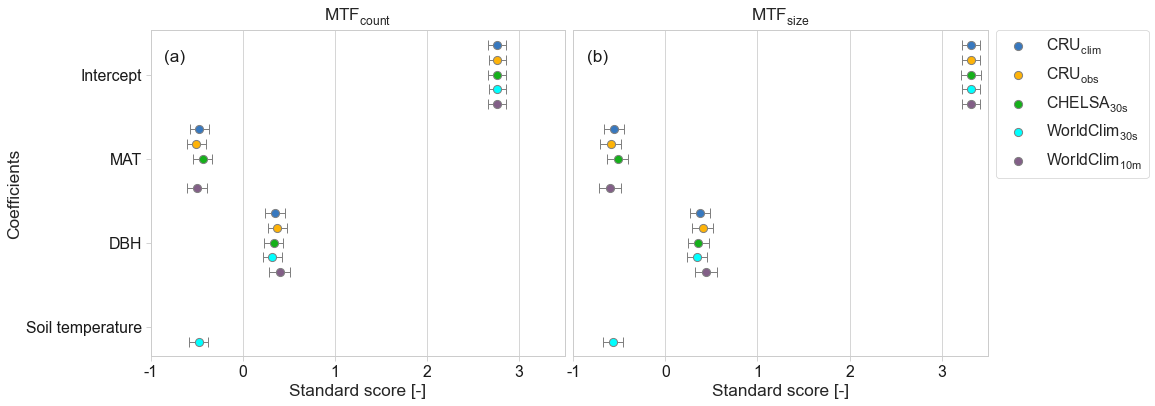

model       climate MTFcount               MTFcmass  \
                                                r2    AIC   RMSE       r2   
0     MTF ~ Temp + DBH_mean       CRUclim     0.23  170.5  24.54     0.26   
1     MTF ~ Temp + DBH_mean     CRUNCEPv7     0.25  167.9  24.23     0.29   
2     MTF ~ Temp + DBH_mean     CHELSA30s      0.2  173.1  25.18     0.23   
3  MTF ~ MAsoilT + DBH_mean  WorldClim30s     0.25  168.4  25.29     0.29   
4     MTF ~ Temp + DBH_mean  WorldClim10m     0.23    170  25.07     0.28   

                 
     AIC   RMSE  
0  179.5  51.19  
1  176.9  50.65  
2  182.8  52.27  
3    177  52.59  
4  177.9  52.02

In [6]:
if ('Fire' not in date_exp_str):
    climate_data_plot  = {'CRUclim':'$CRU_{clim}$',
                          'CRUNCEPv7':'$CRU_{obs}$',
                          'CHELSA30s':'$CHELSA_{30s}$',
                          'WorldClim30s':'$WorldClim_{30s}$',
                          'WorldClim10m':'$WorldClim_{10m}$',}

    # Define plot coefficient labels
    coeff_plot_dict = {'Humidity':'Humidity',
                       'Intercept':'Intercept',
                       'CDI':'CDI',
                       'CN_ratio':'C:N ratio',
                       'PFT':'PFT',
                       'DBH_mean':'DBH',
                       'Fire':'Fire',
                       'MATsoil':'Soil Temperature',
                       'Managed':'Managed',
                       'MAP':'MAP',
                       'Soil_water':'Soil water saturation',
                       'Soil_water_max':'Maximum soil water saturation',
                       'MAT':'MAT',
                       'Wood_density':' Wood density',
                       'Wood_durability': 'Wood durability'}

    se_coef     = np.empty((len(climate_data_list),len(mtf_type)), dtype='object')
    plot_kws = {'linewidth':1,
                 'ecolor':'grey',
                 'capsize':5,
                 'dodge':0.7,
                 'scale':1.5,
                }

    df_clim_compare_count = pd.DataFrame()
    df_clim_compare_cmass = pd.DataFrame()
    mtf_type_plot = ['count','size']

    df_param_array = np.empty((len(climate_data_list),len(mtf_type),), dtype='object')


    for t,tpe in enumerate(mtf_type):
        coef_clims_st_unst = [[],[]] # list for standardised and unstandardised coefficients
        for st in range(len(coef_clims_st_unst)):
            coef_clims_st_unst[st] = pd.concat(res_data[:,st,t,0],axis=0)
            coef_clims_st_unst[st].index.name = 'model'
            coef_clims_st_unst[st].reset_index(drop=False,inplace=True)
            coef_clims_st_unst[st] = coef_clims_st_unst[st][(coef_clims_st_unst[st].prms_sig == True)].copy() # All covariates significant

        std_range    = np.arange(-3,3+1,0.1)
        line_styles  = ['--', '-']
        var_list_in = unique_models_across_climates[0].replace('MTF ~ ','').split(' + ')
        color_dict   = {var_list_in[v]:'C'+str(v) for v in range(len(var_list_in))}

        
        for c,clim in enumerate(climate_data_list):
            var_list_reg = var_list_in # includes the spelling in the regression equations
            
            # Unstandardised 
            clim_models_unst = coef_clims_st_unst[0][(coef_clims_st_unst[0].climate == clim) & (coef_clims_st_unst[0].MTF_basis == tpe)]
            # Standardised
            clim_models_st = coef_clims_st_unst[1][(coef_clims_st_unst[1].climate == clim) & (coef_clims_st_unst[1].MTF_basis == tpe)]
            idx_mod_unst = clim_models_unst.groupby('RMSE').min()['ID'].tolist()[0]
            idx_mod_st = clim_models_st.groupby('RMSE').min()['ID'].tolist()[0]

            df_param_array[c,t] = res_data[c,1,t,1][idx_mod_st].params.to_frame()
            se_coef[c,t]        = res_data[c,1,t,1][idx_mod_st].bse.to_frame()
            
            if t == 0:
                df_clim_compare_count = pd.concat([df_clim_compare_count, 
                                                   res_data[c,0,t,0].iloc[idx_mod_unst].to_frame().T[['climate','r2','AIC','RMSE']]])
            elif t == 1:
                df_clim_compare_cmass = pd.concat([df_clim_compare_cmass, 
                                                   res_data[c,0,t,0].iloc[idx_mod_unst].to_frame().T[['r2','AIC','RMSE']]])
        #--- Concat all mtf types and climates into 1 df in order to keep variables consistent across mtf types
    # Coefficients
    df1                     = pd.concat(df_param_array[:,0], axis=1)
    df2                     = pd.concat(df_param_array[:,1], axis=1)
    cols1                   = pd.MultiIndex.from_tuples(('count',i) for i in climate_data_plot)
    cols2                   = pd.MultiIndex.from_tuples(('cmass',i) for i in climate_data_plot)
    df1.columns             = cols1
    df2.columns             = cols2
    df_param_clim_mtf_types = pd.concat([df1,df2],axis=1)

    # Errors
    df1                     = pd.concat(se_coef[:,0],axis=1)
    df2                     = pd.concat(se_coef[:,1],axis=1)
    df1.columns             = cols1
    df2.columns             = cols2
    df_se_mtf_types         = pd.concat([df1,df2],axis=1)



    # Plot coefficients & errors
    sns.set_context("paper", font_scale=1.8)
    plt.rcParams['axes.titley']  = 1.01    # y is in axes-relative coordinates.

    # Add ticks to the white grid of seaborn
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left']   = True
    plt.rcParams['xtick.color']  = 'lightgrey'
    plt.rcParams['ytick.color']  = 'lightgrey'
    fig, ax= plt.subplots(1,2, figsize=(15,6), sharey=True)

    for t in range(len(mtf_type)):

        # Combine all 
        df_params_all_clims         = df_param_clim_mtf_types[mtf_type[t]]
        df_params_all_clims.columns = climate_data_list

        # Unstack df, to get format usable by sns.catplot
        df_params_all_clims_cat         = df_params_all_clims.unstack().reset_index().copy()
        df_params_all_clims_cat.columns = ['Climate', 'Coefficient', 'Value']
        df_params_all_clims_cat.Climate = df_params_all_clims_cat.Climate.apply(lambda x: climate_data_plot[x])


        # Get plot labels from dict based on unique significnat coeffs included in this experiment
        coeffs_unique_ex = df_params_all_clims_cat.Coefficient.unique().tolist()
        plot_labels      = [coeff_plot_dict[i] for i in coeffs_unique_ex]



        # Get coefficient errors
        se_mtf_type_ex         = df_se_mtf_types[mtf_type[t]]
        se_mtf_type_ex.columns = climate_data_list
        # Remove mask from data - because plt.errorbar() ignores the mask
        se_mtf_masked   = se_mtf_type_ex.unstack().tolist() # !! No transposing !!
        point_mask      = [1 if pd.notnull(i) else 0 for i in se_mtf_masked]
        se_mtf_unmasked = [i for i in se_mtf_masked if pd.notnull(i)]



        g = sns.pointplot(data=df_params_all_clims_cat, 
                          hue='Climate', 
                          x='Value', 
                          y='Coefficient',
                          linestyles='None',
                          dodge=plot_kws['dodge'],
                          ax=ax[t],
                          scale=plot_kws['scale']
                         )
        g.legend_.remove() # Remove subplot legends


        ax[t].set_xlabel("Standard score [-]")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ax[t].set_xticklabels(np.arange(-1,5), color='k')

        if t == 0:
            ax[t].set_ylabel("Coefficients")
        else:
            ax[t].set_ylabel("")
        ax[t].set_title('MTF$_{'+mtf_type_plot[t]+'}$')
        ax[t].set_yticklabels(plot_labels, color='k')
        ax[t].set_xlim(-1, 3.5)


        # Find the x,y coordinates for each point
        x_coords = np.empty((len(se_mtf_masked),))
        y_coords = np.empty((len(se_mtf_masked),))
        colors = []

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            i = 0
            for point_pair in g.collections:
                point_pair.set_edgecolor(plot_kws['ecolor'])
                point_pair.set_linewidth(plot_kws['linewidth'])
                colors.append(point_pair.get_facecolors())
                for x, y in point_pair.get_offsets():
                    x_coords[i] = x
                    y_coords[i] = y
                    i += 1
            x_coords = x_coords[~np.isnan(x_coords)]
            y_coords = y_coords[~np.isnan(y_coords)]      

        # Plot errobars for each point
        ax[t].errorbar(x_coords, y_coords, 
                       xerr=se_mtf_unmasked,
                       ecolor=plot_kws['ecolor'], 
                       elinewidth=plot_kws['linewidth'], 
                       capsize=plot_kws['capsize'],
                       fmt=' ', 
                       zorder=-1, )



    ax[t].legend(bbox_to_anchor=(1,1.025),loc='upper left')
    ax[0].annotate(xy=(-0.85,-0.15),text='(a)',color='k')
    ax[1].annotate(xy=(-0.85,-0.15),text='(b)',color='k')
    ax[1].yaxis.set_ticks_position('none') # Remove ticks only from 2nd plot sharing the yaxis with 1st
    plt.subplots_adjust(wspace=0.02)
    plt.savefig('site_reg_results/'+date_exp_str+'_normCoeff_spe_'+str(remove_data)+'_'+str(alpha)+'_site.png', 
               dpi=300, bbox_inches='tight')
    plt.show() 


    # Display best models by climate
    df_clim_compare_count.index.name = 'model'
    df_clim_compare_count.reset_index(drop=False,inplace=True)
    df_clim_compare_count.set_index(['model','climate'],inplace=True)
    df_clim_compare_cmass.index = df_clim_compare_count.index

    df_clim_compare_count.columns = pd.MultiIndex.from_tuples([('MTFcount',i) for i in df_clim_compare_count.columns])
    df_clim_compare_cmass.columns = pd.MultiIndex.from_tuples([('MTFcmass',i) for i in df_clim_compare_cmass.columns])
    clim_comparison_best = pd.concat([df_clim_compare_count, df_clim_compare_cmass],axis=1)
    clim_comparison_best.reset_index(drop=False, inplace=True)

    clim_comparison_best.model = clim_comparison_best.model
    display(clim_comparison_best)

    with open('site_reg_results/'+date_exp_str+'_best_model_climate_'+str(remove_data)+'_'+str(alpha)+'_site.pkl','wb') as f:
        pickle.dump(clim_comparison_best,f)